In [1]:
# Basic libraries
import pandas as pd
import numpy as np

# ML tools
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    precision_recall_curve,
    recall_score,
    f1_score,
    roc_auc_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

# Scaling
from sklearn.preprocessing import StandardScaler

# Plotting
import matplotlib.pyplot as plt


In [2]:
# Load cleaned dataset for frequency modelling
df = pd.read_csv("../data/data2_cleaned.csv")

# Preview data
df.head()

,policy_id,subscription_length,vehicle_age,customer_age,region_code,region_density,segment,model,fuel_type,max_torque,...,is_brake_assist,is_power_door_locks,is_central_locking,is_power_steering,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert,ncap_rating,claim_status
0,POL045360,9.3,1.2,41,C8,8794,C2,M4,Diesel,250Nm@2750rpm,...,1,1,1,1,1,0,1,1,3,0
1,POL016745,8.2,1.8,35,C2,27003,C1,M9,Diesel,200Nm@1750rpm,...,0,1,1,1,1,1,1,1,4,0
2,POL007194,9.5,0.2,44,C8,8794,C2,M4,Diesel,250Nm@2750rpm,...,1,1,1,1,1,0,1,1,3,0
3,POL018146,5.2,0.4,44,C10,73430,A,M1,CNG,60Nm@3500rpm,...,0,0,0,1,0,0,0,1,0,0
4,POL049011,10.1,1.0,56,C13,5410,B2,M5,Diesel,200Nm@3000rpm,...,0,1,1,1,0,0,1,1,5,0


In [18]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58592 entries, 0 to 58591
Data columns (total 41 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   policy_id                         58592 non-null  object 
 1   subscription_length               58592 non-null  float64
 2   vehicle_age                       58592 non-null  float64
 3   customer_age                      58592 non-null  int64  
 4   region_code                       58592 non-null  object 
 5   region_density                    58592 non-null  int64  
 6   segment                           58592 non-null  object 
 7   model                             58592 non-null  object 
 8   fuel_type                         58592 non-null  object 
 9   max_torque                        58592 non-null  object 
 10  max_power                         58592 non-null  object 
 11  engine_type                       58592 non-null  object 
 12  airb

In [3]:
# Target variable
y = df['claim_status']

# Drop target and identifier columns from predictors
df_features = df.drop(columns=['claim_status', 'policy_id'])

# Handle categorical variables: one-hot encode object columns
df_features = pd.get_dummies(df_features, drop_first=True)

# Fill missing values 
df_features = df_features.fillna(0)

# Final X
X = df_features

In [4]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Scale predictors (important for XGB)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame with column names
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

In [5]:
# Handle imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

print("Class balance before SMOTE:", np.bincount(y_train))
print("Class balance after SMOTE:", np.bincount(y_train_resampled))


Class balance before SMOTE: [38390  2624]
Class balance after SMOTE: [38390 38390]


In [6]:
# Train ML models

# Random Forest
rf_model = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')
rf_model.fit(X_train_resampled, y_train_resampled)

# XGBoost
xgb_model = XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=4,
    random_state=42,
    eval_metric="logloss",
    scale_pos_weight=(sum(y_train==0)/sum(y_train==1))  # imbalance handling
)
xgb_model.fit(X_train_resampled, y_train_resampled)

# GLM baseline (Logistic Regression)
glm_model = LogisticRegression(max_iter=1000, class_weight='balanced')
glm_model.fit(X_train_resampled, y_train_resampled)


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [7]:
# Evaluate performance

def evaluate_model(name, y_true, y_pred, y_prob):
    print(f"\n{name} Performance:")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred, zero_division=0))
    print("Recall:", recall_score(y_true, y_pred, zero_division=0))
    print("F1 Score:", f1_score(y_true, y_pred, zero_division=0))
    print("ROC-AUC:", roc_auc_score(y_true, y_prob))

# Predictions + threshold adjustment
threshold = 0.3  # lower than 0.5 to improve recall

# Random Forest
rf_prob = rf_model.predict_proba(X_test_scaled)[:,1]
rf_pred = (rf_prob >= threshold).astype(int)
evaluate_model("Random Forest", y_test, rf_pred, rf_prob)

# XGBoost
xgb_prob = xgb_model.predict_proba(X_test_scaled)[:,1]
xgb_pred = (xgb_prob >= threshold).astype(int)
evaluate_model("XGBoost", y_test, xgb_pred, xgb_prob)

# GLM
glm_prob = glm_model.predict_proba(X_test_scaled)[:,1]
glm_pred = (glm_prob >= threshold).astype(int)
evaluate_model("GLM", y_test, glm_pred, glm_prob)



Random Forest Performance:
Accuracy: 0.7775628626692457
Precision: 0.08368200836820083
Recall: 0.2491103202846975
F1 Score: 0.12527964205816555
ROC-AUC: 0.5727013615441215

XGBoost Performance:
Accuracy: 0.16173626123563545
Precision: 0.06864422894086328
Recall: 0.9635231316725978
F1 Score: 0.12815809715401455
ROC-AUC: 0.6372598340591067

GLM Performance:
Accuracy: 0.11440436909773581
Precision: 0.06625022523875308
Recall: 0.9813167259786477
F1 Score: 0.12412085748044788
ROC-AUC: 0.6214587189477232


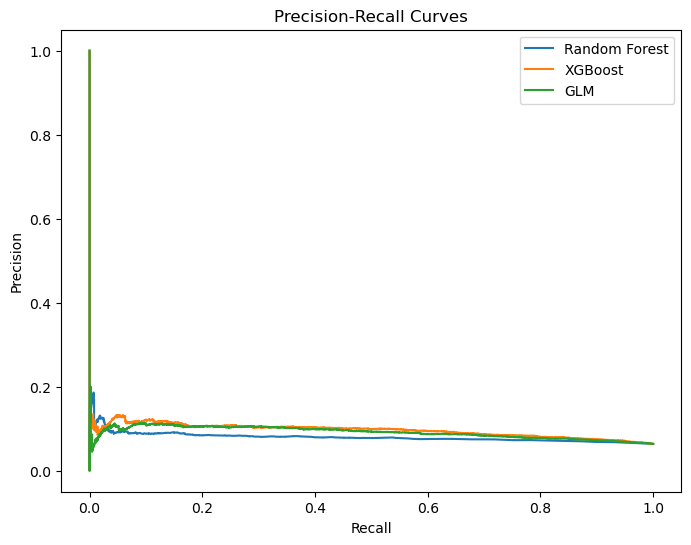

In [8]:
# Precision-Recall curve code(continuation of performance evaluation)

# Random Forest
rf_prob = rf_model.predict_proba(X_test_scaled)[:,1]
precision_rf, recall_rf, _ = precision_recall_curve(y_test, rf_prob)

# XGBoost
xgb_prob = xgb_model.predict_proba(X_test_scaled)[:,1]
precision_xgb, recall_xgb, _ = precision_recall_curve(y_test, xgb_prob)

# GLM
glm_prob = glm_model.predict_proba(X_test_scaled)[:,1]
precision_glm, recall_glm, _ = precision_recall_curve(y_test, glm_prob)

# Plot curves
plt.figure(figsize=(8,6))
plt.plot(recall_rf, precision_rf, label="Random Forest")
plt.plot(recall_xgb, precision_xgb, label="XGBoost")
plt.plot(recall_glm, precision_glm, label="GLM")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves")
plt.legend()
plt.show()


In [9]:
# Interpretation and understanding predictions

# Random Forest feature importance
importances_rf = rf_model.feature_importances_
rf_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances_rf
}).sort_values(by='Importance', ascending=False)

print(rf_importance_df.head(10))  # top 10 features
rf_importance_df.to_csv("../data/rf_feature_importance.csv", index=False)
print("Random Forest feature importance saved.")


# XGBoost feature importance
importances_xgb = xgb_model.feature_importances_
xgb_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances_xgb
}).sort_values(by='Importance', ascending=False)

print(xgb_importance_df.head(10))  # top 10 features
xgb_importance_df.to_csv("../data/xgb_feature_importance.csv", index=False)
print("XGBoost feature importance saved.")


# GLM coefficients
glm_coef_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': glm_model.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

print(glm_coef_df.head(10))   # top positive predictors
print(glm_coef_df.tail(10))   # top negative predictors
glm_coef_df.to_csv("../data/glm_coefficients.csv", index=False)
print("GLM coefficients saved as feature importance.")


                Feature  Importance
0   subscription_length    0.308643
1           vehicle_age    0.297127
2          customer_age    0.283823
3        region_density    0.021639
48       region_code_C8    0.008179
39       region_code_C2    0.004001
45       region_code_C5    0.003928
49       region_code_C9    0.003411
43       region_code_C3    0.003222
47       region_code_C7    0.003061
Random Forest feature importance saved.
                    Feature  Importance
1               vehicle_age    0.078563
71  max_torque_60Nm@3500rpm    0.071133
2              customer_age    0.062535
48           region_code_C8    0.036869
10             displacement    0.031332
96      steering_type_Power    0.031011
0       subscription_length    0.028428
20          is_brake_assist    0.026160
37          region_code_C18    0.025784
52               segment_C1    0.023757
XGBoost feature importance saved.
                Feature  Coefficient
0   subscription_length     0.360309
48       region_

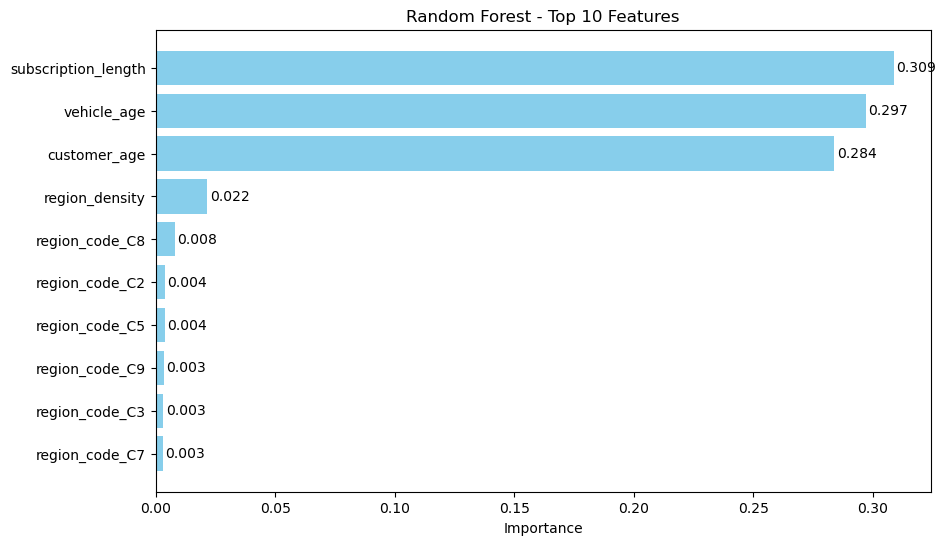

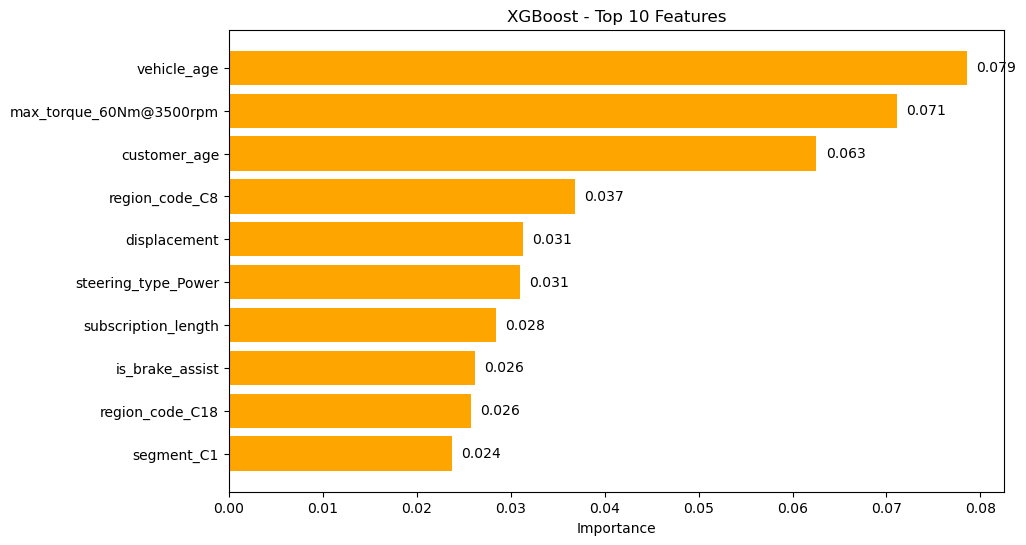

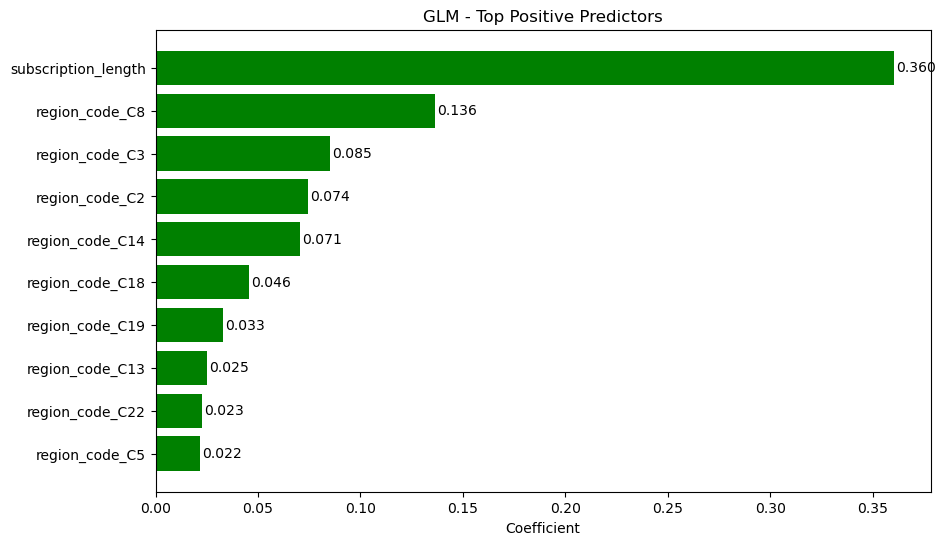

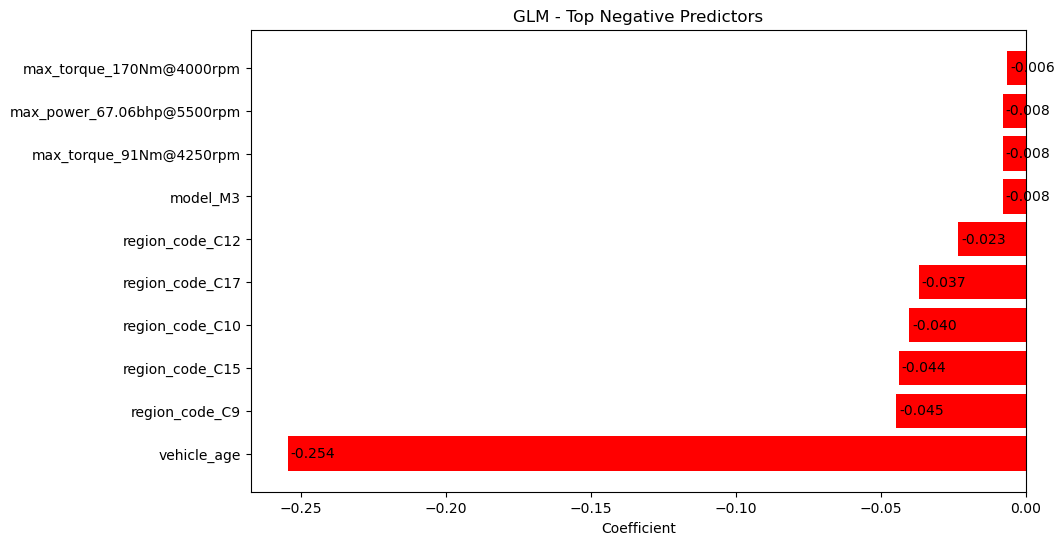

In [10]:
# Visualization of the feature, importance, correlation
def plot_feature_importance(df, feature_col, value_col, title, color):
    plt.figure(figsize=(10,6))
    plt.barh(df[feature_col], df[value_col], color=color)
    plt.xlabel(value_col)
    plt.title(title)
    plt.gca().invert_yaxis()  # highest at top
    
    # Add value labels
    for i, v in enumerate(df[value_col]):
        plt.text(v + 0.001, i, f"{v:.3f}", va='center')
    
    plt.show()

# Random Forest
rf_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False).head(10)

plot_feature_importance(rf_importance_df, 'Feature', 'Importance',
                        "Random Forest - Top 10 Features", 'skyblue')

# XGBoost
xgb_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values(by='Importance', ascending=False).head(10)

plot_feature_importance(xgb_importance_df, 'Feature', 'Importance',
                        "XGBoost - Top 10 Features", 'orange')

# GLM Positive Coefficients
glm_coef_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': glm_model.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

glm_top_positive = glm_coef_df.head(10)
plot_feature_importance(glm_top_positive, 'Feature', 'Coefficient',
                        "GLM - Top Positive Predictors", 'green')

# GLM Negative Coefficients
glm_top_negative = glm_coef_df.tail(10)
plot_feature_importance(glm_top_negative, 'Feature', 'Coefficient',
                        "GLM - Top Negative Predictors", 'red')
